In [ ]:
"""
ポケモン図鑑(https://yakkun.com/sm/zukan/, 2019/3/22取得)からスクレイピングした
ポケモンデータ（781匹、欠損データあり）の種族値について調べる


※種族値(しゅぞくち)とは、各ポケモンの種類ごとに決まっている固有の強さなどの数値の俗称。
https://wiki.xn--rckteqa2e.com/wiki/%E7%A8%AE%E6%97%8F%E5%80%A4

1. データの分布や相関関係などを調べる
2. 種族値からエスパータイプのポケモンを分類する分類器をつくることを目指す


結論

1.
    a. 「こうげき」と「とくぼう」にもっとも負の相関があることを確認。
        「ぼうぎょ」と「すばやさ」、「HP」と「すばやさ」にも確認
 
    b. エスパータイプとそうでない群ではHPとすばやさでは有意な差はなく、
        こうげき、ぼうぎょ、とくこう、とくぼうに有意な差があるとわかった
        
2. 
    a. ロジスティック回帰、ランダムフォレスト分類木、サポートベクトルマシン、均衡ブースティング
    　　　　などで試みたが、良い性能は出せなかった。種族値だけではエスパータイプに分類することは
        困難であることがわかった。
"""

In [78]:
import pandas as pd
import numpy as np

#全ポケモンの種族値に関するデータを読み込む
data = pd.read_csv("pokemon.csv")
data.head()

,名前,番号,HP,こうげき,ぼうぎょ,とくこう,とくぼう,すばやさ,タイプ1,タイプ2
0,フシギダネ,1,45,49,49,65,65,45,くさ,どく
1,フシギソウ,2,60,62,63,80,80,60,くさ,どく
2,フシギバナ,3,80,82,83,100,100,80,くさ,どく
3,ヒトカゲ,4,39,52,43,60,50,65,ほのお,NaN
4,リザード,5,58,64,58,80,65,80,ほのお,NaN


In [107]:
# data.info()
# 多少の違いはあるが、統計的なバランスを保ちながら種族値が設定されていることを確認
data.describe()

,番号,HP,こうげき,ぼうぎょ,とくこう,とくぼう,すばやさ
count,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,407.745198,68.668374,76.133163,71.644046,69.302177,69.729834,65.390525
std,233.440527,26.316932,29.665057,30.007201,29.695089,27.418083,27.527047
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,204.000000,50.000000,55.000000,50.000000,45.000000,50.000000,45.000000
50%,412.000000,65.000000,75.000000,67.000000,65.000000,65.000000,64.000000
75%,609.000000,80.000000,95.000000,90.000000,90.000000,85.000000,85.000000
max,806.000000,255.000000,181.000000,230.000000,173.000000,230.000000,160.000000


In [40]:
#data[data.columns[-2]].value_counts()

In [50]:
data_np = np.array(data)
X = data_np[:, 2:8]
y = data_np[:, 8:]

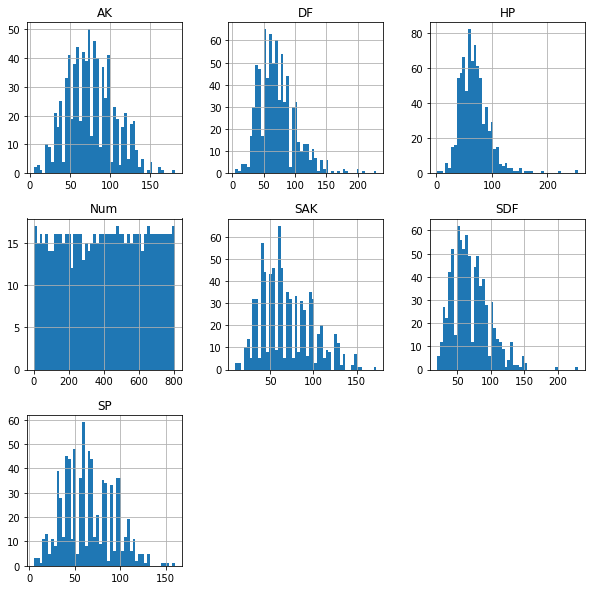

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt

#全ポケモンの各ステータスごとの種族値の分布が同じように割り振られていることを確認
data_hist = data.copy()
data_hist.columns = ["Name", "Num", "HP", "AK", "DF", "SAK", "SDF", "SP", "Type1", "Type2" ]
data_hist.hist(bins=50, figsize=(10,10))
plt.show()

In [187]:
#corr_matrix = data_hist.corr()
#corr_matrix["HP"].sort_values(ascending=False)

In [185]:
#corr_matrix["SAK"].sort_values(ascending=False)

In [186]:
#corr_matrix["SP"].sort_values(ascending=False)

In [190]:
#from pandas.plotting import scatter_matrix

#attributes = [ "HP", "AK", "DF", "SAK", "SDF", "SP"]
#scatter_matrix(data_hist[attributes], figsize=(12, 8))

In [179]:
# 相関関係が多いのでデータを見直す
# ステータスの合計で各ステータスを割る

sm = np.sum(X, axis=1)
data_mod = np.array([x/s for x, s in zip(X, sm)])

In [180]:
# 欠損データを（もしあれば）中央値で置き換える

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(data_mod)
X = imputer.transform(data_mod)

# HP こうげき ぼうぎょ とくこう とくぼう すばやさ
data_tr = pd.DataFrame(X, columns= [ "HP", "AK", "DF", "SAK", "SDF", "SP"])
data_tr.head()

,HP,AK,DF,SAK,SDF,SP
0,0.141509,0.154088,0.154088,0.204403,0.204403,0.141509
1,0.148148,0.153086,0.155556,0.197531,0.197531,0.148148
2,0.152381,0.156190,0.158095,0.190476,0.190476,0.152381
3,0.126214,0.168285,0.139159,0.194175,0.161812,0.210356
4,0.143210,0.158025,0.143210,0.197531,0.160494,0.197531


In [215]:
#corr_matrix = data_tr.corr()
#corr_matrix["HP"].sort_values(ascending=False)

In [216]:
#corr_matrix = data_tr.corr()
#corr_matrix["SAK"].sort_values(ascending=False)

In [217]:
#corr_matrix = data_tr.corr()
#corr_matrix["SP"].sort_values(ascending=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1339c0d68>,
      dtype=object)

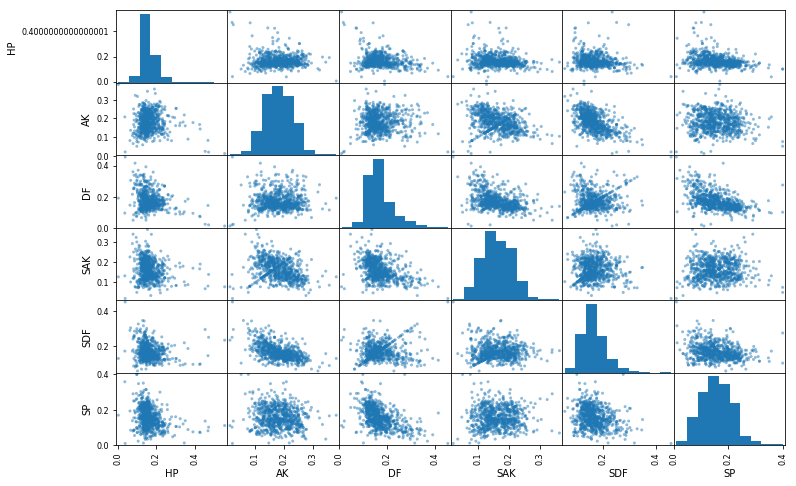

In [204]:
scatter_matrix(data_tr[attributes], figsize=(12, 8))

In [202]:
#corr_matrix

In [218]:
# 対角の1.が常に最大値になってしまうので0にする
corr_matrix_ = corr_matrix - np.eye(corr_matrix.shape[0])
corr_matrix_

,HP,AK,DF,SAK,SDF,SP
HP,0.000000,-0.061141,-0.237038,-0.186501,-0.148082,-0.295373
AK,-0.061141,0.000000,0.010240,-0.335029,-0.558039,-0.110523
DF,-0.237038,0.010240,0.000000,-0.416372,0.110097,-0.499369
SAK,-0.186501,-0.335029,-0.416372,0.000000,-0.017061,0.024506
SDF,-0.148082,-0.558039,0.110097,-0.017061,0.000000,-0.258954
SP,-0.295373,-0.110523,-0.499369,0.024506,-0.258954,0.000000


In [232]:
# 相関係数の絶対値の最大値からもっとも相関するペアを調べる
best_corrs = np.max(np.array(np.abs(corr_matrix_)), axis=0)
best_corrs

array([0.29537298, 0.55803936, 0.49936888, 0.41637225, 0.55803936,
       0.49936888])

In [234]:
# 「こうげき」と「とくぼう」にもっとも負の相関があることを確認。
# 「ぼうぎょ」と「すばやさ」、「HP」と「すばやさ」にも確認

# いわタイプのようなごついポケモンは、ぼうぎょが高い代わりにすばやさが低い、という直感と一致
# またカビゴンのようなHPが高く、からだの大きいポケモンほどすばやさが低い、という直感と一致

labels = ["HP-SP", "AK-SDF", "DF-SP", "SAK-DF", "SDF-AK", "SP-DF"]
df = pd.DataFrame(np.array([-best_corrs]), columns=labels)
df

,HP-SP,AK-SDF,DF-SP,SAK-DF,SDF-AK,SP-DF
0,-0.295373,-0.558039,-0.499369,-0.416372,-0.558039,-0.499369


In [334]:
data_reg = data_hist.copy()
data_reg_X = np.array(data_tr)
data_reg_cat = np.array(data_reg)[:, -2:]

for nan_row in  [row for row in data_reg_cat if type(row[1]) is float]:
    nan_row[1] = "なし"

In [417]:
#タイプの一つがエスパータイプであるポケモンを1、それ以外を0とラベリングする

data_reg_np = np.c_[data_reg_X, data_reg_cat]

esper = np.array(["エスパー" in x for x in data_reg_np[:, -2:]], dtype=int)
data_esper = np.c_[data_reg_X, esper]
data_esper

array([[0.14150943, 0.15408805, 0.15408805, ..., 0.20440252, 0.14150943,
        0.        ],
       [0.14814815, 0.15308642, 0.15555556, ..., 0.19753086, 0.14814815,
        0.        ],
       [0.15238095, 0.15619048, 0.15809524, ..., 0.19047619, 0.15238095,
        0.        ],
       ...,
       [0.13518519, 0.13518519, 0.13518519, ..., 0.13518519, 0.22407407,
        0.        ],
       [0.10701754, 0.22982456, 0.37017544, ..., 0.17719298, 0.02280702,
        0.        ],
       [0.09298246, 0.22280702, 0.09298246, ..., 0.13859649, 0.1877193 ,
        0.        ]])

In [491]:
# エスパータイプのポケモンとそうでないポケモンの各種族値に違いがあるか調べる
# F検定を行い、等分散であるか調べ、そのあとt検定を行う

from sklearn.linear_model import LogisticRegression
from scipy import stats

def t_test(i, equal_var=True):
    data_isesper = data_esper[data_esper[:, -1]==1]
    data_noesper = data_esper[data_esper[:, -1]==0]

    espers = data_isesper[:, i]
    noespers = data_noesper[:, i]

    f = np.var(espers) / np.var(noespers)

    dfx = len(espers) - 1
    dfy = len(noespers) - 1

    p_value = stats.f.cdf(f, dfx, dfy)
    print("{:<30}".format("F test p value: "), p_value)
    t, p = stats.ttest_ind(espers, noespers, equal_var = equal_var)
    print("{:<30}".format("t test p value: "), p)

In [492]:
# SAK, SDFに関してエスパータイプとそうでない群では有意に差があるといえる
# AK, DFに関してはF検定のp値が0.05以下であり、等分散でないので別途行う

columns = [ "HP", "AK", "DF", "SAK", "SDF", "SP"]
print("Esper Pokemon VS No Esper Pokemon")
for i in range(len(columns)):
    print("Comparison: ", columns[i])
    t_test(i)
    print()

Esper Pokemon VS No Esper Pokemon
Comparison:  HP
F test p value:                0.9798672843254211
t test p value:                0.530061756868597

Comparison:  AK
F test p value:                0.023386985771638506
t test p value:                8.802778297964091e-13

Comparison:  DF
F test p value:                0.038706814830905475
t test p value:                0.0679790642033193

Comparison:  SAK
F test p value:                0.9971814536521313
t test p value:                4.848242825600054e-09

Comparison:  SDF
F test p value:                0.30538995532804114
t test p value:                9.87665052629197e-07

Comparison:  SP
F test p value:                0.19019338787411974
t test p value:                0.8094255910913856



In [597]:
# AK, DFに関して、別途t検定を行う

# 結果、AK, DFに関してエスパータイプとそうでない群では有意に差があるといえる

print("Comparison: ", columns[1])
t_test(1, equal_var = False)
print("Comparison: ", columns[2])
t_test(2, equal_var = False)

# 結論
# エスパータイプとそうでない群ではHPとSPでは有意な差はなく、
# AK, DF, SAK, SDFに有意な差があるとわかった

Comparison:  AK
F test p value:                0.023386985771638506
t test p value:                3.2758786883372043e-13
Comparison:  DF
F test p value:                0.038706814830905475
t test p value:                0.0409427438748598


In [520]:
# AK, DF, SAK, SDFの変数を用いて種族値からエスパータイプのポケモンを分類するモデルを作る

data_ad = np.c_[data_esper[:, 1:5], data_esper[:, -1]]
data_ad_df = pd.DataFrame(data_ad, columns=["AK", "DF", "SAK", "SDF", "ESP"])
data_ad_df.head()
data_ad_df["ESP"].value_counts()

0.0    704
1.0     77
Name: ESP, dtype: int64

In [586]:
# 訓練データとテストデータで「エスパータイプと非エスパータイプ」の比率が等しくなるよう
# Stratifiedサンプリングを行う

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_ad_df, data_ad_df["ESP"]):
    train_set = data_ad_df.loc[train_index]
    test_set= data_ad_df.loc[test_index]
    
print("Train set: \n", train_set["ESP"].value_counts())
print("Test set: \n", test_set["ESP"].value_counts())

Train set: 
 0.0    562
1.0     62
Name: ESP, dtype: int64
Test set: 
 0.0    142
1.0     15
Name: ESP, dtype: int64


In [594]:
# ロジスティック回帰、ランダムフォレスト分類木、サポートベクトルマシンのアンサンブル学習で分類器をつくる
# 正解率を表示
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

log_clf  = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting="hard"
)

train_set_np = np.array(train_set)
test_set_np = np.array(test_set)

voting_clf.fit(train_set_np[:, :-1], train_set_np[:, -1])
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(train_set_np[:, :-1], train_set_np[:, -1])
    y_pred = clf.predict(test_set_np[:, :-1])

    print(clf.__class__.__name__, accuracy_score(test_set_np[:, -1], y_pred ))

LogisticRegression 0.9044585987261147
RandomForestClassifier 0.9171974522292994
SVC 0.9044585987261147
VotingClassifier 0.9044585987261147


In [559]:
# グリッドサーチで最適なパラメータを探しながら勾配ブースティングで分類器をつくる
# まずは最適なパラメータを表示

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 8, 10],
        'max_depth': [2,3,4],
        'learning_rate': [0.5, 0.7, 1.0]
    }
]

gbrt = GradientBoostingClassifier()
grid_search = GridSearchCV(
    gbrt, param_grid,
    cv=2,
    scoring="neg_mean_squared_error",
    return_train_score=True
)

grid_search.fit(train_set_np[:, :-1], train_set_np[:, -1])
grid_search.best_params_


{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 3}

In [560]:
cvres = grid_search.cv_results_
results = []
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    results.append((np.sqrt(-mean_score), params))

sorted(results, key=lambda x: x[0])[:5]

[(0.327676356900822,
  {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 3}),
 (0.3396831102433787,
  {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 10}),
 (0.3396831102433787,
  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 3}),
 (0.3396831102433787,
  {'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 3}),
 (0.34203388646036154,
  {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 8})]

In [556]:
# 正解率を表示
# ただし前のアンサンブル学習と結果が類似→
# データがskewed dataであるため（全データについて、エスパータイプと非エスパータイプの比率が同じでない）
final_model = grid_search.best_estimator_

final_pred = final_model.predict(test_set_np[:, :-1])
accuracy_score(test_set_np[:, -1], y_pred )

0.9044585987261147

In [595]:
# skewedデータの分類の性能を調べる
# あまり分類ができてないことを確認

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

data_ad_np = np.array(data_ad_df)
y_train_pred = cross_val_predict(final_model, data_ad_np[:, :-1], data_ad_np[:, -1])
conf_mat = confusion_matrix(data_ad_np[:, -1], y_train_pred)
conf_mat

# True Negative : 680
# False Negative: 73
# False Positive: 24
# True Positive: 4

# False Negative,　つまりエスパーなのにエスパーではないと分類されたものが多い

array([[679,  25],
       [ 73,   4]])

In [596]:
# ロジスティック回帰、ランダムフォレスト分類木、サポートベクトルマシンの場合でも調べる
# あまり分類ができてないことを確認

voting_clf.fit(train_set_np[:, :-1], train_set_np[:, -1])
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    y_train_pred = cross_val_predict(clf, data_ad_np[:, :-1], data_ad_np[:, -1])

    print(clf.__class__.__name__)
    print(confusion_matrix(data_ad_np[:, -1], y_train_pred))

LogisticRegression
[[704   0]
 [ 77   0]]
RandomForestClassifier
[[688  16]
 [ 71   6]]
SVC
[[704   0]
 [ 77   0]]
VotingClassifier
[[704   0]
 [ 77   0]]
